# Vehicle Price and Condition Prediction:
## CSC 365 - Programming Workshop II

**Student Name**: Ibrahim Haydar, Christina ElHaddad, Charbel Elias, Nehmatallah El Tahan

**Student ID**: 202302967, 202303144, 202401043, 202301396

This project implements two machine learning tasks on a vehicle dataset:
1. **Regression**: Predicting vehicle prices based on vehicle characteristics
2. **Classification**: Predicting vehicle condition categories

### Dataset Summary

- **Features**: 26 columns including price, year, manufacturer, model, condition, etc.
- **Target Variables**: 
  - Price (continuous - regression)
  - Condition (categorical - classification)

### Evaluation Strategy

This project uses **both train-test split and k-fold cross-validation** to ensure robust model evaluation:
- **Train-Test Split (80/20)**: Quick evaluation and final model testing
- **5-Fold Cross-Validation**: More reliable performance estimates by averaging over multiple splits

## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Loading

In [2]:
df = pd.read_csv('vehicles.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (426880, 26)

First few rows:


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [3]:
# Dataset info
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-nu

In [4]:
# Check for missing values
print("Missing Values Count:")
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})
missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

Missing Values Count:


,Column,Missing_Count,Missing_Percentage
21,county,426880,100.00
16,size,306361,71.77
9,cylinders,177678,41.62
8,condition,174104,40.79
14,VIN,161042,37.73
15,drive,130567,30.59
18,paint_color,130203,30.50
17,type,92858,21.75
6,manufacturer,17646,4.13
12,title_status,8242,1.93


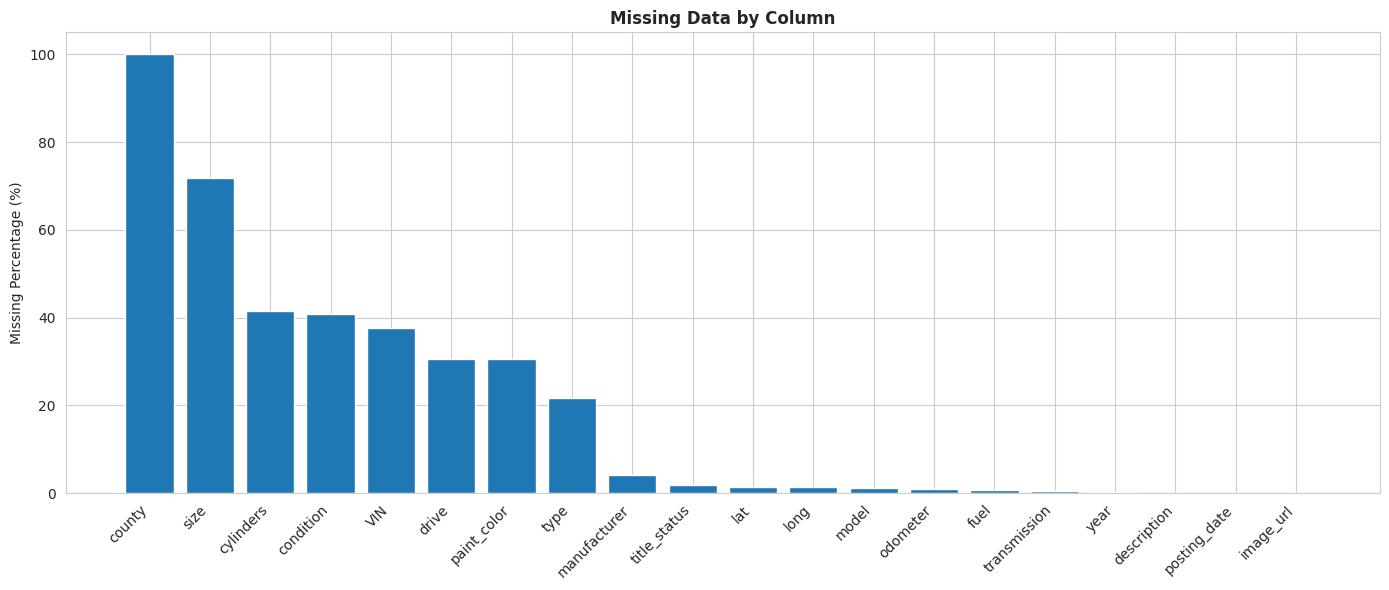

In [5]:
# Visualize missing data
plt.figure(figsize=(14, 6))
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]
plt.bar(range(len(missing_pct)), missing_pct.values)
plt.xticks(range(len(missing_pct)), missing_pct.index, rotation=45, ha='right')
plt.ylabel('Missing Percentage (%)')
plt.title('Missing Data by Column', fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# Basic statistics for numerical columns
print("\nBasic Statistics:")
df.describe()


Basic Statistics:


,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


In [7]:
# Explore target variables
print("Price Statistics:")
print(f"Mean: ${df['price'].mean():,.2f}")
print(f"Median: ${df['price'].median():,.2f}")
print(f"Std Dev: ${df['price'].std():,.2f}")
print(f"Min: ${df['price'].min():,.2f}")
print(f"Max: ${df['price'].max():,.2f}")

print("\n" + "="*50)
print("\nCondition Distribution:")
print(df['condition'].value_counts())
print(f"\nMissing condition values: {df['condition'].isnull().sum()} ({df['condition'].isnull().sum()/len(df)*100:.2f}%)")

Price Statistics:
Mean: $75,199.03
Median: $13,950.00
Std Dev: $12,182,282.17
Min: $0.00
Max: $3,736,928,711.00


Condition Distribution:
condition
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: count, dtype: int64

Missing condition values: 174104 (40.79%)
condition
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: count, dtype: int64

Missing condition values: 174104 (40.79%)


## 3. Data Cleaning

In [8]:
# Create a copy for cleaning
df_clean = df.copy()

print(f"Original dataset size: {len(df_clean)} rows")

# Drop non-predictive columns
columns_to_drop = ['id', 'url', 'region_url', 'VIN', 'county', 'image_url', 'description', 'posting_date']
df_clean = df_clean.drop(columns=columns_to_drop)
print(f"\nAfter dropping non-predictive columns: {len(df_clean)} rows, {len(df_clean.columns)} columns")

# Remove price outliers (prices = 0 or > $500,000)
df_clean = df_clean[(df_clean['price'] > 0) & (df_clean['price'] <= 500000)]
print(f"After removing price outliers: {len(df_clean)} rows")

# Remove rows with missing target values
df_clean = df_clean.dropna(subset=['price', 'condition'])
print(f"After removing rows with missing targets: {len(df_clean)} rows")

# Remove rows with any remaining missing values
df_clean = df_clean.dropna()
print(f"\nFinal cleaned dataset: {len(df_clean)} rows, {len(df_clean.columns)} columns")
print(f"Percentage of original data retained: {len(df_clean)/len(df)*100:.2f}%")

Original dataset size: 426880 rows

After dropping non-predictive columns: 426880 rows, 18 columns
After removing price outliers: 393917 rows

After dropping non-predictive columns: 426880 rows, 18 columns
After removing price outliers: 393917 rows
After removing rows with missing targets: 242568 rows
After removing rows with missing targets: 242568 rows

Final cleaned dataset: 75581 rows, 18 columns
Percentage of original data retained: 17.71%

Final cleaned dataset: 75581 rows, 18 columns
Percentage of original data retained: 17.71%


In [9]:
# Check the cleaned dataset
print("Cleaned Dataset Info:")
print(f"Shape: {df_clean.shape}")
print(f"\nMissing values: {df_clean.isnull().sum().sum()}")
print("\nColumns remaining:")
print(df_clean.columns.tolist())

Cleaned Dataset Info:
Shape: (75581, 18)

Missing values: 0

Columns remaining:
['region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long']


In [10]:
# Display sample of cleaned data
df_clean.head(10)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,32.592000,-85.518900
55,auburn,19900,2004.0,ford,f250 super duty,good,8 cylinders,diesel,88000.0,clean,automatic,4wd,full-size,pickup,blue,al,32.547500,-85.468200
59,auburn,14000,2012.0,honda,odyssey,excellent,6 cylinders,gas,95000.0,clean,automatic,fwd,full-size,mini-van,silver,al,32.628739,-85.461820
65,auburn,22500,2001.0,ford,f450,good,8 cylinders,diesel,144700.0,clean,manual,rwd,full-size,truck,white,al,32.630400,-85.401600
73,auburn,15000,2017.0,dodge,charger rt 4dr sedan,excellent,8 cylinders,gas,90000.0,rebuilt,automatic,rwd,mid-size,sedan,grey,al,32.822400,-85.770400
86,auburn,3000,2004.0,chrysler,town & country,good,6 cylinders,gas,176144.0,clean,automatic,fwd,mid-size,mini-van,silver,al,32.629409,-85.484447
110,auburn,9500,2003.0,chrysler,town & country,excellent,6 cylinders,gas,30376.0,clean,automatic,fwd,mid-size,mini-van,blue,al,32.614209,-85.326357
119,auburn,17500,2008.0,toyota,fj cruiser,good,6 cylinders,gas,201300.0,clean,manual,4wd,full-size,offroad,black,al,32.602400,-85.487300
138,auburn,4000,2006.0,jeep,grand cherokee laredo,good,6 cylinders,gas,281000.0,clean,automatic,rwd,mid-size,SUV,black,al,32.609900,-85.480800
177,birmingham,22950,2014.0,ford,f150 supercrew cab xlt,excellent,8 cylinders,gas,166380.0,clean,automatic,4wd,full-size,truck,black,al,33.384664,-86.737847


## 4. Data Analysis

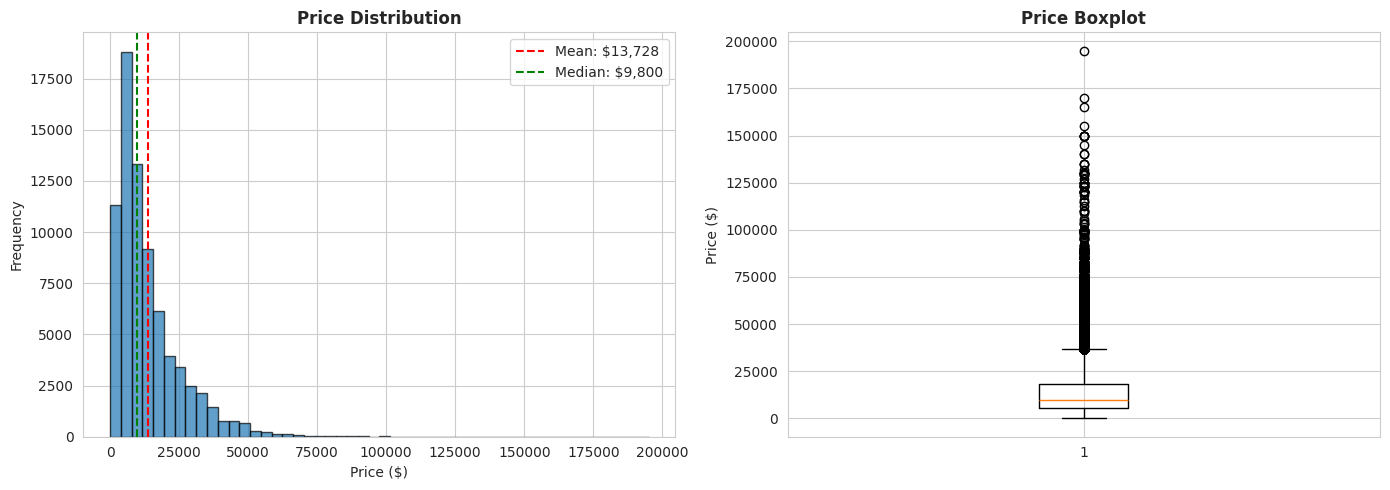

In [11]:
# Price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_clean['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution', fontweight='bold')
axes[0].axvline(df_clean['price'].mean(), color='red', linestyle='--', label=f'Mean: ${df_clean["price"].mean():,.0f}')
axes[0].axvline(df_clean['price'].median(), color='green', linestyle='--', label=f'Median: ${df_clean["price"].median():,.0f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(df_clean['price'])
axes[1].set_ylabel('Price ($)')
axes[1].set_title('Price Boxplot', fontweight='bold')

plt.tight_layout()
plt.show()

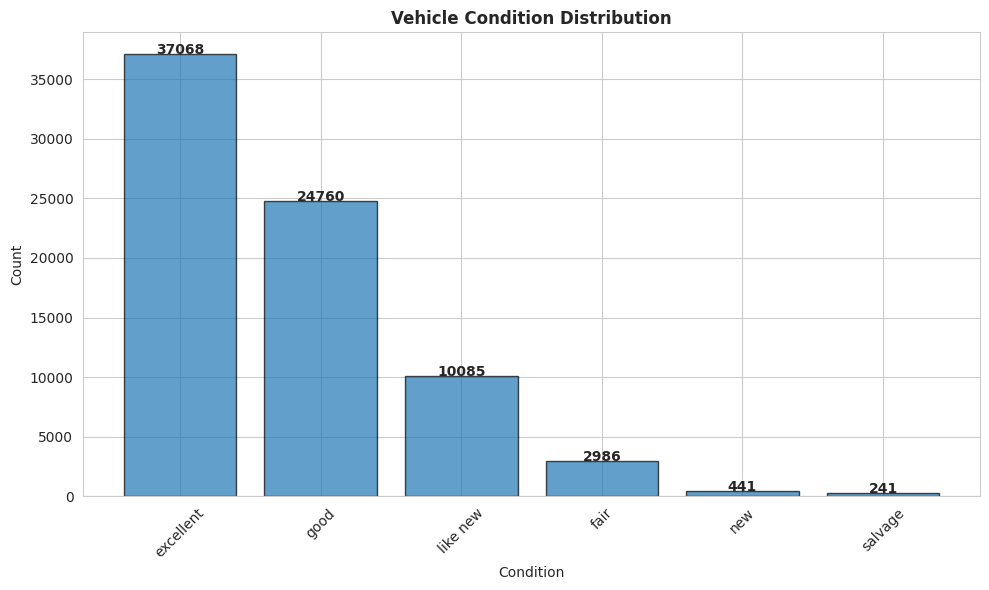

In [12]:
# Condition distribution
plt.figure(figsize=(10, 6))
condition_counts = df_clean['condition'].value_counts()
plt.bar(condition_counts.index, condition_counts.values, edgecolor='black', alpha=0.7)
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Vehicle Condition Distribution', fontweight='bold')
plt.xticks(rotation=45)
for i, v in enumerate(condition_counts.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

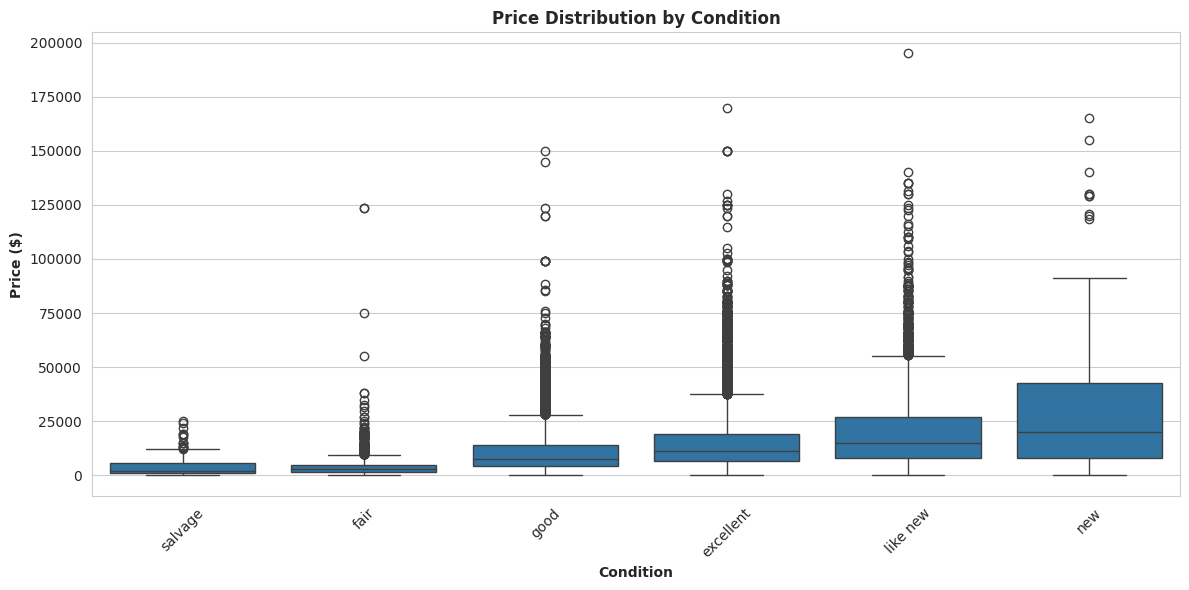

In [13]:
# Price by condition
plt.figure(figsize=(12, 6))
condition_order = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
condition_order = [c for c in condition_order if c in df_clean['condition'].unique()]
sns.boxplot(data=df_clean, x='condition', y='price', order=condition_order)
plt.xlabel('Condition', fontweight='bold')
plt.ylabel('Price ($)', fontweight='bold')
plt.title('Price Distribution by Condition', fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

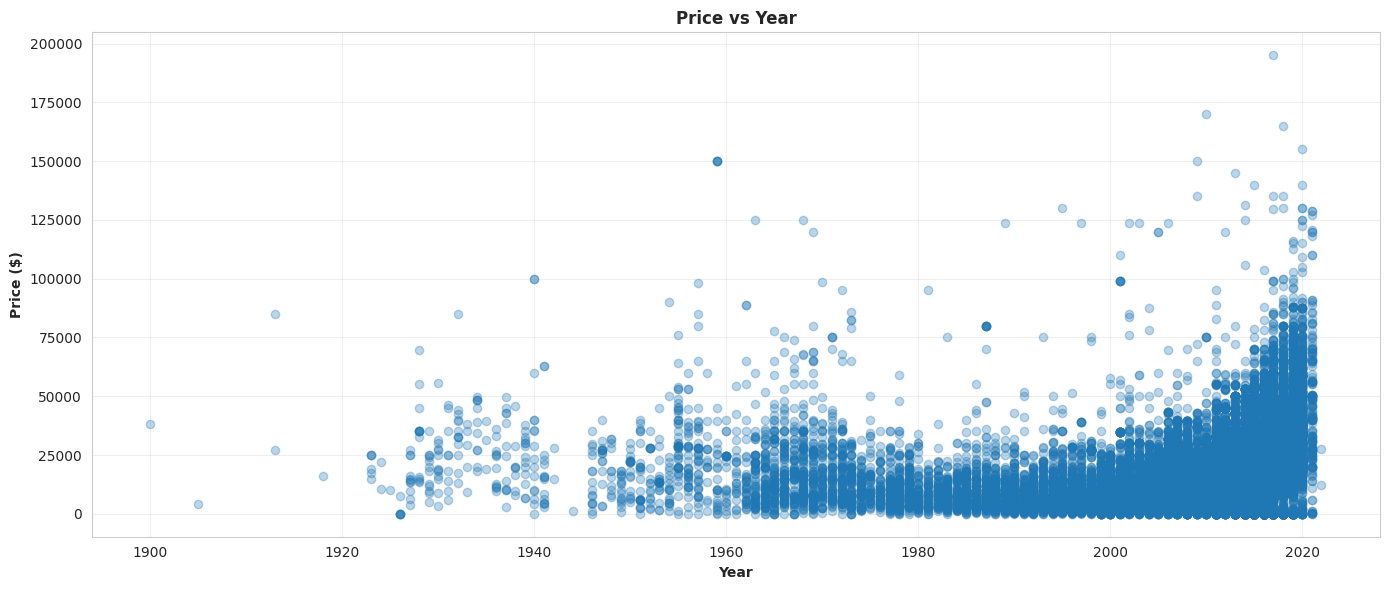

In [14]:
# Price by year
plt.figure(figsize=(14, 6))
plt.scatter(df_clean['year'], df_clean['price'], alpha=0.3)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Price ($)', fontweight='bold')
plt.title('Price vs Year', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

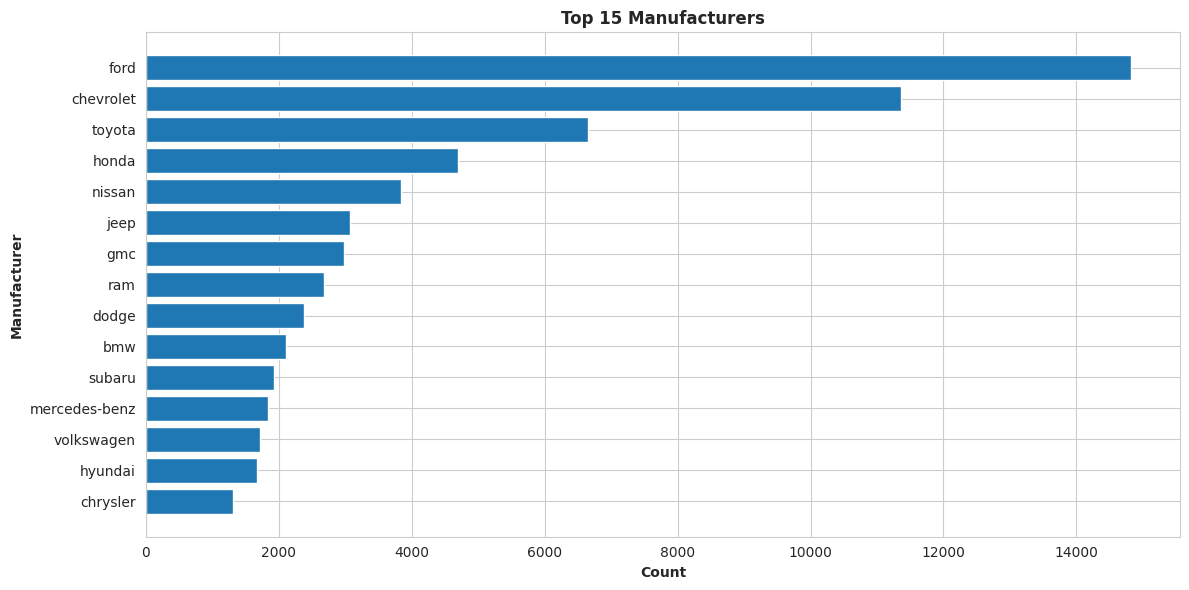

In [15]:
# Top manufacturers
plt.figure(figsize=(12, 6))
top_manufacturers = df_clean['manufacturer'].value_counts().head(15)
plt.barh(range(len(top_manufacturers)), top_manufacturers.values)
plt.yticks(range(len(top_manufacturers)), top_manufacturers.index)
plt.xlabel('Count', fontweight='bold')
plt.ylabel('Manufacturer', fontweight='bold')
plt.title('Top 15 Manufacturers', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

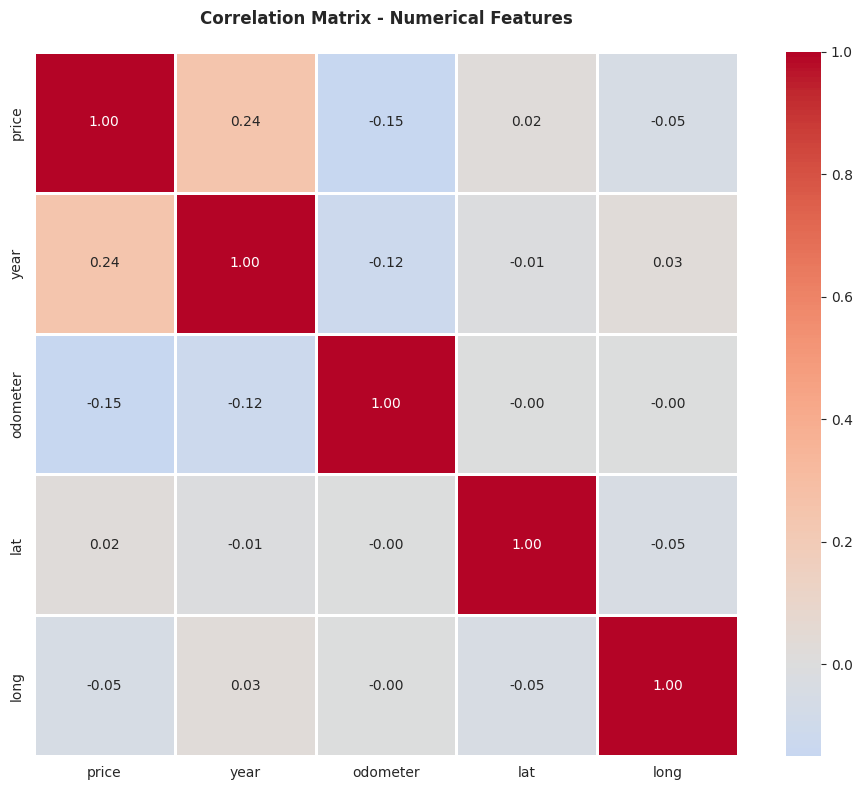

In [16]:
# Correlation heatmap for numerical features
numerical_cols = ['price', 'year', 'odometer', 'lat', 'long']
correlation_matrix = df_clean[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Correlation Matrix - Numerical Features', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [17]:
# Create a copy for feature engineering
df_features = df_clean.copy()

# Create vehicle age feature
current_year = 2021
df_features['vehicle_age'] = current_year - df_features['year']

# Create price per 1000 miles feature
df_features['price_per_1k_miles'] = df_features['price'] / (df_features['odometer'] / 1000 + 1)

print("New features created:")
print(f"- vehicle_age: ranges from {df_features['vehicle_age'].min()} to {df_features['vehicle_age'].max()} years")
print(f"- price_per_1k_miles: ranges from ${df_features['price_per_1k_miles'].min():.2f} to ${df_features['price_per_1k_miles'].max():.2f}")

New features created:
- vehicle_age: ranges from -1.0 to 121.0 years
- price_per_1k_miles: ranges from $0.00 to $163043.48


In [18]:
# Display engineered features
df_features[['year', 'vehicle_age', 'odometer', 'price', 'price_per_1k_miles']].head(10)

,year,vehicle_age,odometer,price,price_per_1k_miles
31,2013.0,8.0,128000.0,15000,116.279070
55,2004.0,17.0,88000.0,19900,223.595506
59,2012.0,9.0,95000.0,14000,145.833333
65,2001.0,20.0,144700.0,22500,154.426905
73,2017.0,4.0,90000.0,15000,164.835165
86,2004.0,17.0,176144.0,3000,16.935375
110,2003.0,18.0,30376.0,9500,302.779194
119,2008.0,13.0,201300.0,17500,86.505190
138,2006.0,15.0,281000.0,4000,14.184397
177,2014.0,7.0,166380.0,22950,137.113156


---
# PART 1: PRICE PREDICTION (REGRESSION)
---

## 6. Regression: Data Preparation

In [19]:
# Prepare data for regression (price prediction)
df_regression = df_features.copy()

# Select features for regression
features_to_encode = ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 
                      'size', 'type', 'paint_color', 'state', 'region']

# Encode categorical variables
label_encoders_reg = {}
for col in features_to_encode:
    le = LabelEncoder()
    df_regression[col + '_encoded'] = le.fit_transform(df_regression[col].astype(str))
    label_encoders_reg[col] = le

# Encode condition for use as a feature
le_condition = LabelEncoder()
df_regression['condition_encoded'] = le_condition.fit_transform(df_regression['condition'])

print("Categorical encoding complete for regression")
print(f"\nTotal features available: {len(df_regression.columns)}")

Categorical encoding complete for regression

Total features available: 31


In [20]:
# Select features for regression model
feature_columns_reg = ['year', 'vehicle_age', 'odometer', 'lat', 'long',
                       'manufacturer_encoded', 'fuel_encoded', 'title_status_encoded',
                       'transmission_encoded', 'drive_encoded', 'size_encoded',
                       'type_encoded', 'paint_color_encoded', 'condition_encoded',
                       'state_encoded', 'region_encoded']

X_reg = df_regression[feature_columns_reg]
y_reg = df_regression['price']

print(f"Regression feature matrix shape: {X_reg.shape}")
print(f"Regression target shape: {y_reg.shape}")
print(f"\nFeatures used for price prediction:")
for i, col in enumerate(feature_columns_reg, 1):
    print(f"{i}. {col}")

Regression feature matrix shape: (75581, 16)
Regression target shape: (75581,)

Features used for price prediction:
1. year
2. vehicle_age
3. odometer
4. lat
5. long
6. manufacturer_encoded
7. fuel_encoded
8. title_status_encoded
9. transmission_encoded
10. drive_encoded
11. size_encoded
12. type_encoded
13. paint_color_encoded
14. condition_encoded
15. state_encoded
16. region_encoded


In [21]:
# Split the data - 80% train, 20% test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train_reg)} samples")
print(f"Test set size: {len(X_test_reg)} samples")
print(f"\nTraining set price range: ${y_train_reg.min():,.2f} - ${y_train_reg.max():,.2f}")
print(f"Test set price range: ${y_test_reg.min():,.2f} - ${y_test_reg.max():,.2f}")

Training set size: 60464 samples
Test set size: 15117 samples

Training set price range: $1.00 - $195,000.00
Test set price range: $1.00 - $169,999.00


In [22]:
# Scale the features
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print("Feature scaling complete")
print(f"\nScaled training data shape: {X_train_reg_scaled.shape}")
print(f"Scaled test data shape: {X_test_reg_scaled.shape}")

Feature scaling complete

Scaled training data shape: (60464, 16)
Scaled test data shape: (15117, 16)


## 7. Regression: Model Training and Comparison

### Train-Test Split Evaluation

In [23]:
# Initialize regression models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=100, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=-1)
}

print("Regression models initialized:")
for name in regression_models.keys():
    print(f"- {name}")

Regression models initialized:
- Linear Regression
- Ridge
- Random Forest
- Gradient Boosting
- XGBoost


In [24]:
# Train and evaluate all regression models with train-test split
regression_results = {}

print("Training regression models with Train-Test Split...\n")
print("="*80)

for name, model in regression_models.items():
    print(f"\n{name}:")
    print("-" * 40)
    
    # Use scaled data for Linear and Ridge, original for tree-based
    if name in ['Linear Regression', 'Ridge']:
        X_train_use = X_train_reg_scaled
        X_test_use = X_test_reg_scaled
    else:
        X_train_use = X_train_reg
        X_test_use = X_test_reg
    
    # Train
    model.fit(X_train_use, y_train_reg)
    
    # Predict
    y_pred_train = model.predict(X_train_use)
    y_pred_test = model.predict(X_test_use)
    
    # Calculate metrics
    train_r2 = r2_score(y_train_reg, y_pred_train)
    test_r2 = r2_score(y_test_reg, y_pred_test)
    test_mae = mean_absolute_error(y_test_reg, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_test))
    
    # Store results
    regression_results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'mae': test_mae,
        'rmse': test_rmse,
        'predictions': y_pred_test
    }
    
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"MAE: ${test_mae:,.2f}")
    print(f"RMSE: ${test_rmse:,.2f}")

print("\n" + "="*80)
print("Train-Test Split evaluation complete!")

Training regression models with Train-Test Split...


Linear Regression:
----------------------------------------
Training R²: 0.2021
Test R²: 0.2008
MAE: $7,830.42
RMSE: $11,192.39

Ridge:
----------------------------------------
Training R²: 0.2021
Test R²: 0.2008
MAE: $7,830.97
RMSE: $11,192.21

Random Forest:
----------------------------------------
Training R²: 0.2021
Test R²: 0.2008
MAE: $7,830.97
RMSE: $11,192.21

Random Forest:
----------------------------------------
Training R²: 0.9651
Test R²: 0.8139
MAE: $2,828.16
RMSE: $5,401.05

Gradient Boosting:
----------------------------------------
Training R²: 0.9651
Test R²: 0.8139
MAE: $2,828.16
RMSE: $5,401.05

Gradient Boosting:
----------------------------------------
Training R²: 0.7916
Test R²: 0.7714
MAE: $3,552.18
RMSE: $5,985.65

XGBoost:
----------------------------------------
Training R²: 0.7916
Test R²: 0.7714
MAE: $3,552.18
RMSE: $5,985.65

XGBoost:
----------------------------------------
Training R²: 0.8533
Test R²

### Cross-Validation Evaluation

**Why Cross-Validation?**
- More reliable performance estimates by testing on multiple data splits
- Reduces dependency on a single train-test split
- Better detects overfitting
- Standard practice for robust model evaluation

In [25]:
# Perform 5-Fold Cross-Validation for regression
print("Performing 5-Fold Cross-Validation for Regression Models...\n")
print("="*80)

cv_results_reg = {}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create custom scorers for MAE and RMSE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

for name, model in regression_models.items():
    print(f"\n{name}:")
    print("-" * 40)
    
    # Choose scaled or unscaled data
    if name in ['Linear Regression', 'Ridge']:
        X_use = scaler_reg.fit_transform(X_reg)
    else:
        X_use = X_reg
    
    # Perform cross-validation for R²
    cv_r2_scores = cross_val_score(model, X_use, y_reg, cv=kfold, scoring='r2', n_jobs=-1)
    
    # Perform cross-validation for MAE
    cv_mae_scores = -cross_val_score(model, X_use, y_reg, cv=kfold, scoring=mae_scorer, n_jobs=-1)
    
    # Perform cross-validation for RMSE
    cv_rmse_scores = -cross_val_score(model, X_use, y_reg, cv=kfold, scoring=rmse_scorer, n_jobs=-1)
    
    # Store results
    cv_results_reg[name] = {
        'cv_r2_mean': cv_r2_scores.mean(),
        'cv_r2_std': cv_r2_scores.std(),
        'cv_mae_mean': cv_mae_scores.mean(),
        'cv_mae_std': cv_mae_scores.std(),
        'cv_rmse_mean': cv_rmse_scores.mean(),
        'cv_rmse_std': cv_rmse_scores.std()
    }
    
    print(f"CV R² (mean ± std): {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")
    print(f"CV MAE (mean ± std): ${cv_mae_scores.mean():,.2f} ± ${cv_mae_scores.std():,.2f}")
    print(f"CV RMSE (mean ± std): ${cv_rmse_scores.mean():,.2f} ± ${cv_rmse_scores.std():,.2f}")

print("\n" + "="*80)
print("Cross-validation complete!")

Performing 5-Fold Cross-Validation for Regression Models...


Linear Regression:
----------------------------------------
CV R² (mean ± std): 0.1981 ± 0.0114
CV MAE (mean ± std): $7,899.75 ± $94.66
CV RMSE (mean ± std): $11,182.17 ± $100.72

Ridge:
----------------------------------------
CV R² (mean ± std): 0.1981 ± 0.0114
CV MAE (mean ± std): $7,899.75 ± $94.66
CV RMSE (mean ± std): $11,182.17 ± $100.72

Ridge:
----------------------------------------
CV R² (mean ± std): 0.1991 ± 0.0113
CV MAE (mean ± std): $7,829.58 ± $59.12
CV RMSE (mean ± std): $11,175.31 ± $97.16

Random Forest:
----------------------------------------
CV R² (mean ± std): 0.1991 ± 0.0113
CV MAE (mean ± std): $7,829.58 ± $59.12
CV RMSE (mean ± std): $11,175.31 ± $97.16

Random Forest:
----------------------------------------
CV R² (mean ± std): 0.8024 ± 0.0118
CV MAE (mean ± std): $2,825.90 ± $18.37
CV RMSE (mean ± std): $5,549.04 ± $190.54

Gradient Boosting:
----------------------------------------
CV R² (mean ±

### Regression Results Comparison

In [26]:
# Create comprehensive comparison dataframe
regression_comparison = pd.DataFrame({
    'Model': list(regression_results.keys()),
    'Test R²': [regression_results[m]['test_r2'] for m in regression_results.keys()],
    'CV R² (Mean)': [cv_results_reg[m]['cv_r2_mean'] for m in cv_results_reg.keys()],
    'CV R² (Std)': [cv_results_reg[m]['cv_r2_std'] for m in cv_results_reg.keys()],
    'Test MAE ($)': [regression_results[m]['mae'] for m in regression_results.keys()],
    'CV MAE (Mean)': [cv_results_reg[m]['cv_mae_mean'] for m in cv_results_reg.keys()],
    'Test RMSE ($)': [regression_results[m]['rmse'] for m in regression_results.keys()],
    'CV RMSE (Mean)': [cv_results_reg[m]['cv_rmse_mean'] for m in cv_results_reg.keys()]
})

regression_comparison = regression_comparison.sort_values('CV R² (Mean)', ascending=False)
print("\nRegression Model Comparison (Train-Test vs Cross-Validation):")
print("="*100)
regression_comparison


Regression Model Comparison (Train-Test vs Cross-Validation):


,Model,Test R²,CV R² (Mean),CV R² (Std),Test MAE ($),CV MAE (Mean),Test RMSE ($),CV RMSE (Mean)
2,Random Forest,0.813895,0.802430,0.011829,2828.161274,2825.904355,5401.051104,5549.035694
4,XGBoost,0.806619,0.794376,0.012684,3200.346058,3208.584714,5505.615919,5660.800507
3,Gradient Boosting,0.771428,0.761364,0.010044,3552.182231,3556.490697,5985.646667,6099.583667
1,Ridge,0.200841,0.199116,0.011337,7830.972433,7829.575968,11192.209897,11175.312615
0,Linear Regression,0.200815,0.198136,0.011435,7830.421213,7899.751926,11192.389453,11182.169749


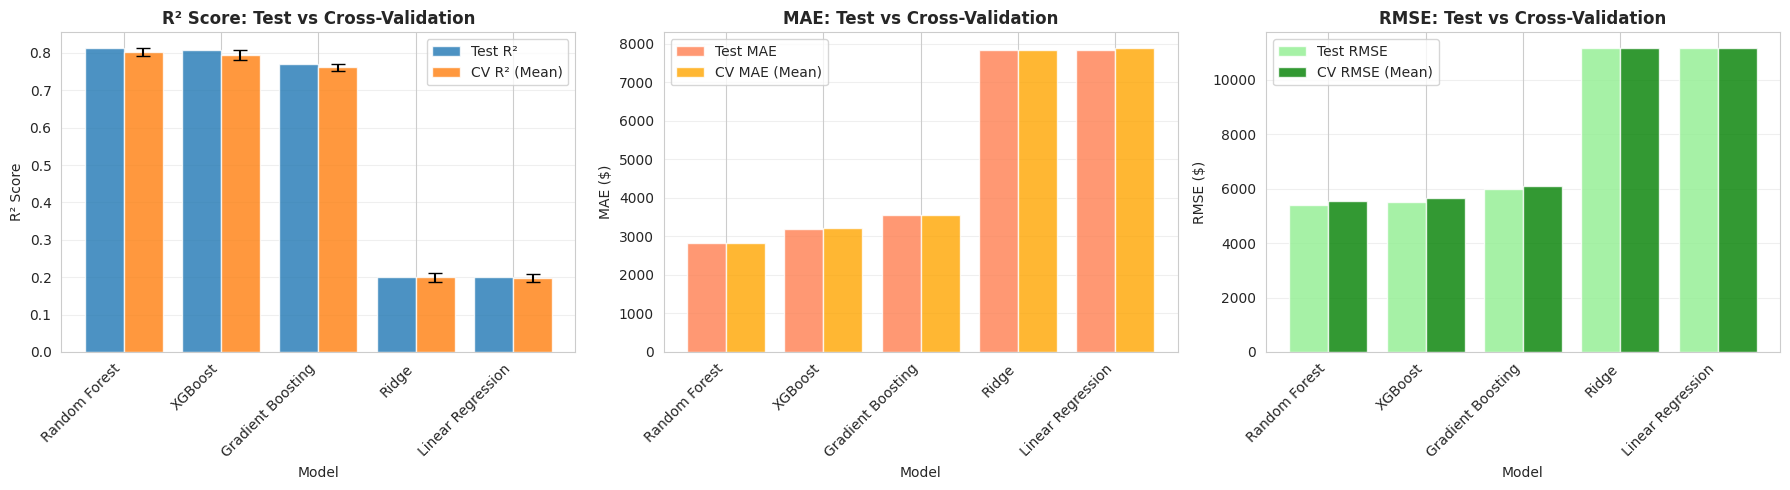

In [27]:
# Visualize comparison between train-test and CV results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = regression_comparison['Model']
x_pos = np.arange(len(models))

# R² comparison
axes[0].bar(x_pos - 0.2, regression_comparison['Test R²'], 0.4, label='Test R²', alpha=0.8)
axes[0].bar(x_pos + 0.2, regression_comparison['CV R² (Mean)'], 0.4, label='CV R² (Mean)', alpha=0.8)
axes[0].errorbar(x_pos + 0.2, regression_comparison['CV R² (Mean)'], 
                yerr=regression_comparison['CV R² (Std)'], fmt='none', color='black', capsize=5)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score: Test vs Cross-Validation', fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# MAE comparison
axes[1].bar(x_pos - 0.2, regression_comparison['Test MAE ($)'], 0.4, label='Test MAE', alpha=0.8, color='coral')
axes[1].bar(x_pos + 0.2, regression_comparison['CV MAE (Mean)'], 0.4, label='CV MAE (Mean)', alpha=0.8, color='orange')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('MAE ($)')
axes[1].set_title('MAE: Test vs Cross-Validation', fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[2].bar(x_pos - 0.2, regression_comparison['Test RMSE ($)'], 0.4, label='Test RMSE', alpha=0.8, color='lightgreen')
axes[2].bar(x_pos + 0.2, regression_comparison['CV RMSE (Mean)'], 0.4, label='CV RMSE (Mean)', alpha=0.8, color='green')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('RMSE ($)')
axes[2].set_title('RMSE: Test vs Cross-Validation', fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(models, rotation=45, ha='right')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Regression: Best Model Analysis

In [28]:
# Select best model based on CV R² (more reliable than single test)
best_model_name_reg = regression_comparison.iloc[0]['Model']
best_model_reg = regression_results[best_model_name_reg]['model']
best_predictions_reg = regression_results[best_model_name_reg]['predictions']

print(f"Best Regression Model (based on CV R²): {best_model_name_reg}")
print("="*80)
print("\nTrain-Test Split Results:")
print(f"Test R²: {regression_results[best_model_name_reg]['test_r2']:.4f}")
print(f"MAE: ${regression_results[best_model_name_reg]['mae']:,.2f}")
print(f"RMSE: ${regression_results[best_model_name_reg]['rmse']:,.2f}")
print("\nCross-Validation Results:")
print(f"CV R² (mean ± std): {cv_results_reg[best_model_name_reg]['cv_r2_mean']:.4f} ± {cv_results_reg[best_model_name_reg]['cv_r2_std']:.4f}")
print(f"CV MAE (mean ± std): ${cv_results_reg[best_model_name_reg]['cv_mae_mean']:,.2f} ± ${cv_results_reg[best_model_name_reg]['cv_mae_std']:,.2f}")
print(f"CV RMSE (mean ± std): ${cv_results_reg[best_model_name_reg]['cv_rmse_mean']:,.2f} ± ${cv_results_reg[best_model_name_reg]['cv_rmse_std']:,.2f}")

Best Regression Model (based on CV R²): Random Forest

Train-Test Split Results:
Test R²: 0.8139
MAE: $2,828.16
RMSE: $5,401.05

Cross-Validation Results:
CV R² (mean ± std): 0.8024 ± 0.0118
CV MAE (mean ± std): $2,825.90 ± $18.37
CV RMSE (mean ± std): $5,549.04 ± $190.54


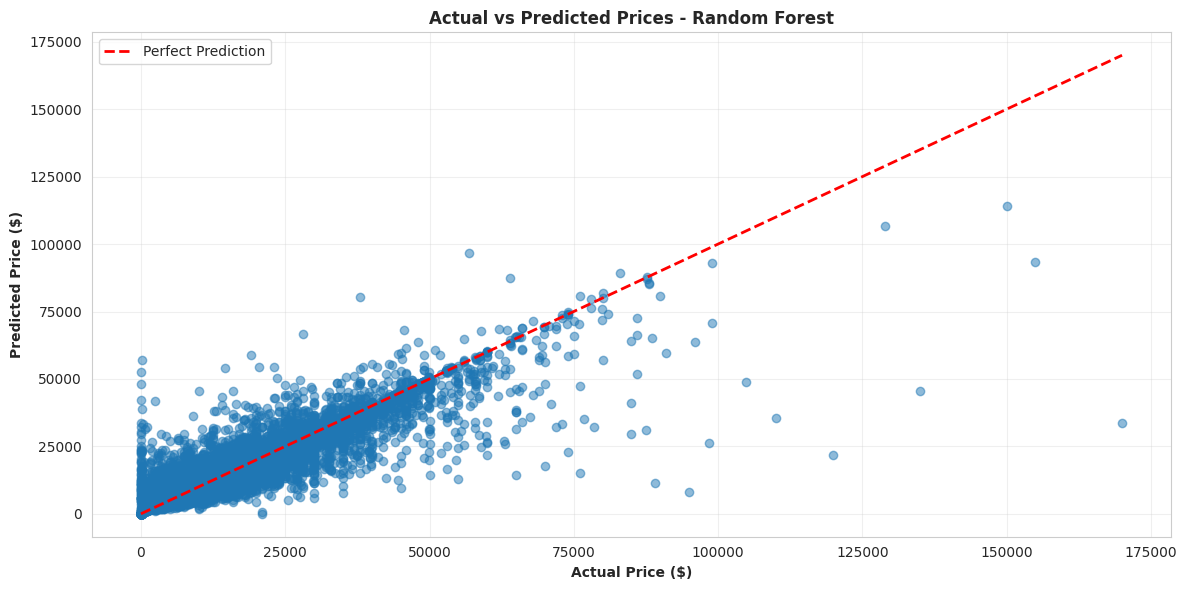

In [29]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test_reg, best_predictions_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)', fontweight='bold')
plt.ylabel('Predicted Price ($)', fontweight='bold')
plt.title(f'Actual vs Predicted Prices - {best_model_name_reg}', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

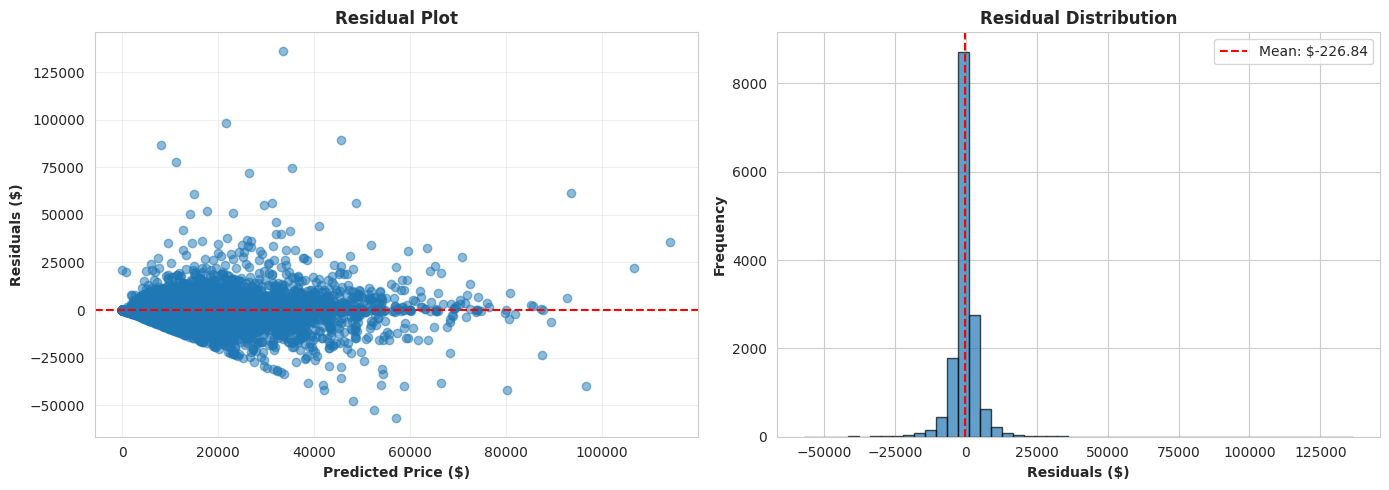

In [30]:
# Residual plot
residuals = y_test_reg - best_predictions_reg

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Predicted
axes[0].scatter(best_predictions_reg, residuals, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Price ($)', fontweight='bold')
axes[0].set_ylabel('Residuals ($)', fontweight='bold')
axes[0].set_title('Residual Plot', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals ($)', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title('Residual Distribution', fontweight='bold')
axes[1].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: ${residuals.mean():,.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

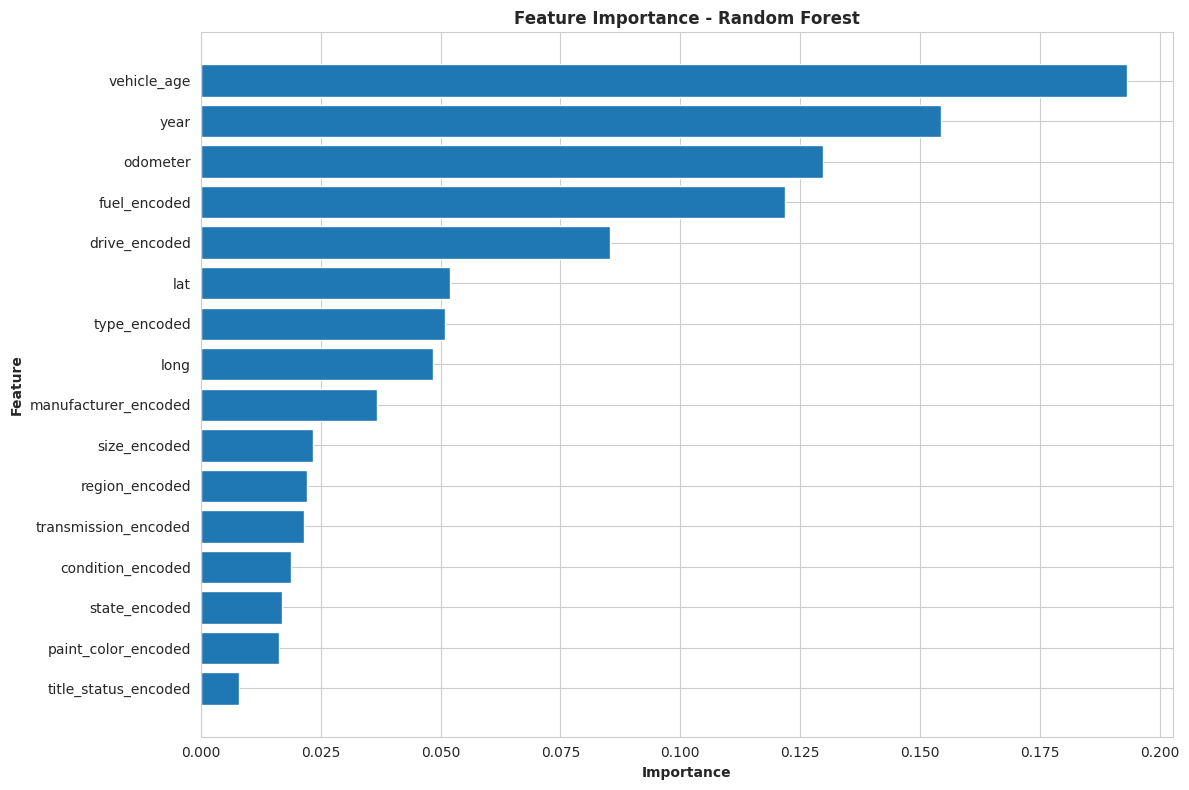


Top 10 Most Important Features:
                 Feature  Importance
1            vehicle_age    0.193163
0                   year    0.154456
2               odometer    0.129857
6           fuel_encoded    0.121925
9          drive_encoded    0.085377
3                    lat    0.052074
11          type_encoded    0.050883
4                   long    0.048472
5   manufacturer_encoded    0.036754
10          size_encoded    0.023408


In [31]:
# Feature importance (for tree-based models)
if hasattr(best_model_reg, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_columns_reg,
        'Importance': best_model_reg.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance)), feature_importance['Importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
    plt.xlabel('Importance', fontweight='bold')
    plt.ylabel('Feature', fontweight='bold')
    plt.title(f'Feature Importance - {best_model_name_reg}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
else:
    print(f"{best_model_name_reg} does not support feature importance visualization")

---
# PART 2: CONDITION PREDICTION (CLASSIFICATION)
---

## 9. Classification: Data Preparation

In [32]:
# Prepare data for classification (condition prediction)
df_classification = df_features.copy()

# Check class distribution
print("Condition Class Distribution:")
print(df_classification['condition'].value_counts())
print(f"\nTotal samples: {len(df_classification)}")

Condition Class Distribution:
condition
excellent    37068
good         24760
like new     10085
fair          2986
new            441
salvage        241
Name: count, dtype: int64

Total samples: 75581


In [33]:
# Encode categorical variables for classification
features_to_encode_clf = ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 
                          'size', 'type', 'paint_color', 'state', 'region']

label_encoders_clf = {}
for col in features_to_encode_clf:
    le = LabelEncoder()
    df_classification[col + '_encoded'] = le.fit_transform(df_classification[col].astype(str))
    label_encoders_clf[col] = le

# Encode target variable (condition)
le_target = LabelEncoder()
df_classification['condition_encoded'] = le_target.fit_transform(df_classification['condition'])

print("Categorical encoding complete for classification")
print(f"\nCondition label mapping:")
for i, label in enumerate(le_target.classes_):
    print(f"{i}: {label}")

Categorical encoding complete for classification

Condition label mapping:
0: excellent
1: fair
2: good
3: like new
4: new
5: salvage


In [34]:
# Select features for classification model
feature_columns_clf = ['price', 'year', 'vehicle_age', 'odometer', 'lat', 'long',
                       'manufacturer_encoded', 'fuel_encoded', 'title_status_encoded',
                       'transmission_encoded', 'drive_encoded', 'size_encoded',
                       'type_encoded', 'paint_color_encoded', 'state_encoded', 'region_encoded']

X_clf = df_classification[feature_columns_clf]
y_clf = df_classification['condition_encoded']

print(f"Classification feature matrix shape: {X_clf.shape}")
print(f"Classification target shape: {y_clf.shape}")
print(f"\nFeatures used for condition prediction:")
for i, col in enumerate(feature_columns_clf, 1):
    print(f"{i}. {col}")

Classification feature matrix shape: (75581, 16)
Classification target shape: (75581,)

Features used for condition prediction:
1. price
2. year
3. vehicle_age
4. odometer
5. lat
6. long
7. manufacturer_encoded
8. fuel_encoded
9. title_status_encoded
10. transmission_encoded
11. drive_encoded
12. size_encoded
13. type_encoded
14. paint_color_encoded
15. state_encoded
16. region_encoded


In [35]:
# Split the data - 80% train, 20% test with stratification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f"Training set size: {len(X_train_clf)} samples")
print(f"Test set size: {len(X_test_clf)} samples")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train_clf).value_counts().sort_index())
print(f"\nTest set class distribution:")
print(pd.Series(y_test_clf).value_counts().sort_index())

Training set size: 60464 samples
Test set size: 15117 samples

Training set class distribution:
condition_encoded
0    29654
1     2389
2    19807
3     8068
4      353
5      193
Name: count, dtype: int64

Test set class distribution:
condition_encoded
0    7414
1     597
2    4953
3    2017
4      88
5      48
Name: count, dtype: int64


In [36]:
# Scale the features
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print("Feature scaling complete for classification")
print(f"\nScaled training data shape: {X_train_clf_scaled.shape}")
print(f"Scaled test data shape: {X_test_clf_scaled.shape}")

Feature scaling complete for classification

Scaled training data shape: (60464, 16)
Scaled test data shape: (15117, 16)


## 10. Classification: Model Training and Comparison

### Train-Test Split Evaluation

In [37]:
# Initialize classification models
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    #'SVM': SVC(kernel='rbf', random_state=42)
}

print("Classification models initialized:")
for name in classification_models.keys():
    print(f"- {name}")

Classification models initialized:
- Logistic Regression
- Random Forest
- Gradient Boosting
- XGBoost


In [38]:
# Train and evaluate all classification models with train-test split
classification_results = {}

print("Training classification models with Train-Test Split...\n")
print("="*80)

for name, model in classification_models.items():
    print(f"\n{name}:")
    print("-" * 40)
    
    # Use scaled data for Logistic Regression, original for tree-based
    if name in ['Logistic Regression']:
        X_train_use = X_train_clf_scaled
        X_test_use = X_test_clf_scaled
    else:
        X_train_use = X_train_clf
        X_test_use = X_test_clf
    
    # Train
    model.fit(X_train_use, y_train_clf)
    
    # Predict
    y_pred_train = model.predict(X_train_use)
    y_pred_test = model.predict(X_test_use)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train_clf, y_pred_train)
    test_acc = accuracy_score(y_test_clf, y_pred_test)
    test_f1 = f1_score(y_test_clf, y_pred_test, average='weighted')
    
    # Store results
    classification_results[name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'f1_score': test_f1,
        'predictions': y_pred_test
    }
    
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"F1 Score (Weighted): {test_f1:.4f}")

print("\n" + "="*80)
print("Train-Test Split evaluation complete!")

Training classification models with Train-Test Split...


Logistic Regression:
----------------------------------------
Training Accuracy: 0.5339
Test Accuracy: 0.5369
F1 Score (Weighted): 0.4716

Random Forest:
----------------------------------------
Training Accuracy: 0.5339
Test Accuracy: 0.5369
F1 Score (Weighted): 0.4716

Random Forest:
----------------------------------------
Training Accuracy: 0.9702
Test Accuracy: 0.7082
F1 Score (Weighted): 0.6940

Gradient Boosting:
----------------------------------------
Training Accuracy: 0.9702
Test Accuracy: 0.7082
F1 Score (Weighted): 0.6940

Gradient Boosting:
----------------------------------------
Training Accuracy: 0.7001
Test Accuracy: 0.6524
F1 Score (Weighted): 0.6345

XGBoost:
----------------------------------------
Training Accuracy: 0.7001
Test Accuracy: 0.6524
F1 Score (Weighted): 0.6345

XGBoost:
----------------------------------------
Training Accuracy: 0.7196
Test Accuracy: 0.6620
F1 Score (Weighted): 0.6429

Train-Tes

### Cross-Validation Evaluation

**Using Stratified K-Fold** for classification to maintain class proportions in each fold.

In [39]:
# Perform 5-Fold Stratified Cross-Validation for classification
print("Performing 5-Fold Stratified Cross-Validation for Classification Models...\n")
print("="*80)

cv_results_clf = {}
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create scorer for F1
f1_scorer = make_scorer(f1_score, average='weighted')

for name, model in classification_models.items():
    print(f"\n{name}:")
    print("-" * 40)
    
    # Choose scaled or unscaled data
    if name in ['Logistic Regression']:
        X_use = scaler_clf.fit_transform(X_clf)
    else:
        X_use = X_clf
    
    # Perform cross-validation for accuracy
    cv_acc_scores = cross_val_score(model, X_use, y_clf, cv=skfold, scoring='accuracy', n_jobs=-1)
    
    # Perform cross-validation for F1
    cv_f1_scores = cross_val_score(model, X_use, y_clf, cv=skfold, scoring=f1_scorer, n_jobs=-1)
    
    # Store results
    cv_results_clf[name] = {
        'cv_acc_mean': cv_acc_scores.mean(),
        'cv_acc_std': cv_acc_scores.std(),
        'cv_f1_mean': cv_f1_scores.mean(),
        'cv_f1_std': cv_f1_scores.std()
    }
    
    print(f"CV Accuracy (mean ± std): {cv_acc_scores.mean():.4f} ± {cv_acc_scores.std():.4f}")
    print(f"CV F1 Score (mean ± std): {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")

print("\n" + "="*80)
print("Cross-validation complete!")

Performing 5-Fold Stratified Cross-Validation for Classification Models...


Logistic Regression:
----------------------------------------
CV Accuracy (mean ± std): 0.5339 ± 0.0021
CV F1 Score (mean ± std): 0.4685 ± 0.0019

Random Forest:
----------------------------------------
CV Accuracy (mean ± std): 0.5339 ± 0.0021
CV F1 Score (mean ± std): 0.4685 ± 0.0019

Random Forest:
----------------------------------------
CV Accuracy (mean ± std): 0.7078 ± 0.0038
CV F1 Score (mean ± std): 0.6929 ± 0.0041

Gradient Boosting:
----------------------------------------
CV Accuracy (mean ± std): 0.7078 ± 0.0038
CV F1 Score (mean ± std): 0.6929 ± 0.0041

Gradient Boosting:
----------------------------------------
CV Accuracy (mean ± std): 0.6548 ± 0.0027
CV F1 Score (mean ± std): 0.6366 ± 0.0030

XGBoost:
----------------------------------------
CV Accuracy (mean ± std): 0.6548 ± 0.0027
CV F1 Score (mean ± std): 0.6366 ± 0.0030

XGBoost:
----------------------------------------
CV Accuracy (mean ±

### Classification Results Comparison

In [40]:
# Create comprehensive comparison dataframe
classification_comparison = pd.DataFrame({
    'Model': list(classification_results.keys()),
    'Test Accuracy': [classification_results[m]['test_acc'] for m in classification_results.keys()],
    'CV Accuracy (Mean)': [cv_results_clf[m]['cv_acc_mean'] for m in cv_results_clf.keys()],
    'CV Accuracy (Std)': [cv_results_clf[m]['cv_acc_std'] for m in cv_results_clf.keys()],
    'Test F1 Score': [classification_results[m]['f1_score'] for m in classification_results.keys()],
    'CV F1 Score (Mean)': [cv_results_clf[m]['cv_f1_mean'] for m in cv_results_clf.keys()],
    'CV F1 Score (Std)': [cv_results_clf[m]['cv_f1_std'] for m in cv_results_clf.keys()]
})

classification_comparison = classification_comparison.sort_values('CV Accuracy (Mean)', ascending=False)
print("\nClassification Model Comparison (Train-Test vs Cross-Validation):")
print("="*100)
classification_comparison


Classification Model Comparison (Train-Test vs Cross-Validation):


,Model,Test Accuracy,CV Accuracy (Mean),CV Accuracy (Std),Test F1 Score,CV F1 Score (Mean),CV F1 Score (Std)
1,Random Forest,0.708209,0.707784,0.003833,0.694021,0.692913,0.004124
3,XGBoost,0.662036,0.662415,0.001506,0.642931,0.643727,0.001865
2,Gradient Boosting,0.652378,0.654834,0.002676,0.634504,0.636626,0.003025
0,Logistic Regression,0.536879,0.533864,0.002125,0.471576,0.468469,0.001872


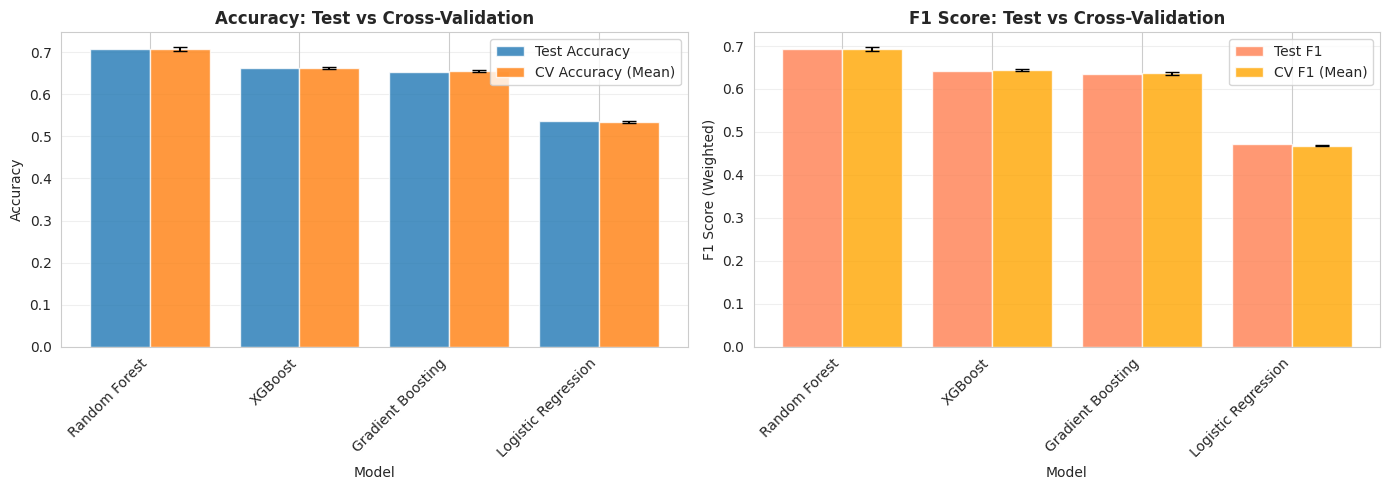

In [41]:
# Visualize comparison between train-test and CV results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = classification_comparison['Model']
x_pos = np.arange(len(models))

# Accuracy comparison
axes[0].bar(x_pos - 0.2, classification_comparison['Test Accuracy'], 0.4, label='Test Accuracy', alpha=0.8)
axes[0].bar(x_pos + 0.2, classification_comparison['CV Accuracy (Mean)'], 0.4, label='CV Accuracy (Mean)', alpha=0.8)
axes[0].errorbar(x_pos + 0.2, classification_comparison['CV Accuracy (Mean)'], 
                yerr=classification_comparison['CV Accuracy (Std)'], fmt='none', color='black', capsize=5)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy: Test vs Cross-Validation', fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# F1 Score comparison
axes[1].bar(x_pos - 0.2, classification_comparison['Test F1 Score'], 0.4, label='Test F1', alpha=0.8, color='coral')
axes[1].bar(x_pos + 0.2, classification_comparison['CV F1 Score (Mean)'], 0.4, label='CV F1 (Mean)', alpha=0.8, color='orange')
axes[1].errorbar(x_pos + 0.2, classification_comparison['CV F1 Score (Mean)'], 
                yerr=classification_comparison['CV F1 Score (Std)'], fmt='none', color='black', capsize=5)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1 Score (Weighted)')
axes[1].set_title('F1 Score: Test vs Cross-Validation', fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Classification: Best Model Analysis

In [42]:
# Select best model based on CV Accuracy (more reliable)
best_model_name_clf = classification_comparison.iloc[0]['Model']
best_model_clf = classification_results[best_model_name_clf]['model']
best_predictions_clf = classification_results[best_model_name_clf]['predictions']

print(f"Best Classification Model (based on CV Accuracy): {best_model_name_clf}")
print("="*80)
print("\nTrain-Test Split Results:")
print(f"Test Accuracy: {classification_results[best_model_name_clf]['test_acc']:.4f}")
print(f"F1 Score: {classification_results[best_model_name_clf]['f1_score']:.4f}")
print("\nCross-Validation Results:")
print(f"CV Accuracy (mean ± std): {cv_results_clf[best_model_name_clf]['cv_acc_mean']:.4f} ± {cv_results_clf[best_model_name_clf]['cv_acc_std']:.4f}")
print(f"CV F1 Score (mean ± std): {cv_results_clf[best_model_name_clf]['cv_f1_mean']:.4f} ± {cv_results_clf[best_model_name_clf]['cv_f1_std']:.4f}")

Best Classification Model (based on CV Accuracy): Random Forest

Train-Test Split Results:
Test Accuracy: 0.7082
F1 Score: 0.6940

Cross-Validation Results:
CV Accuracy (mean ± std): 0.7078 ± 0.0038
CV F1 Score (mean ± std): 0.6929 ± 0.0041


In [43]:
# Detailed classification report
print("\nDetailed Classification Report:")
print("="*80)
print(classification_report(y_test_clf, best_predictions_clf, 
                          target_names=le_target.classes_))


Detailed Classification Report:
              precision    recall  f1-score   support

   excellent       0.70      0.87      0.78      7414
        fair       0.56      0.25      0.34       597
        good       0.70      0.66      0.68      4953
    like new       0.85      0.42      0.56      2017
         new       0.82      0.38      0.52        88
     salvage       1.00      0.08      0.15        48

    accuracy                           0.71     15117
   macro avg       0.77      0.44      0.50     15117
weighted avg       0.72      0.71      0.69     15117



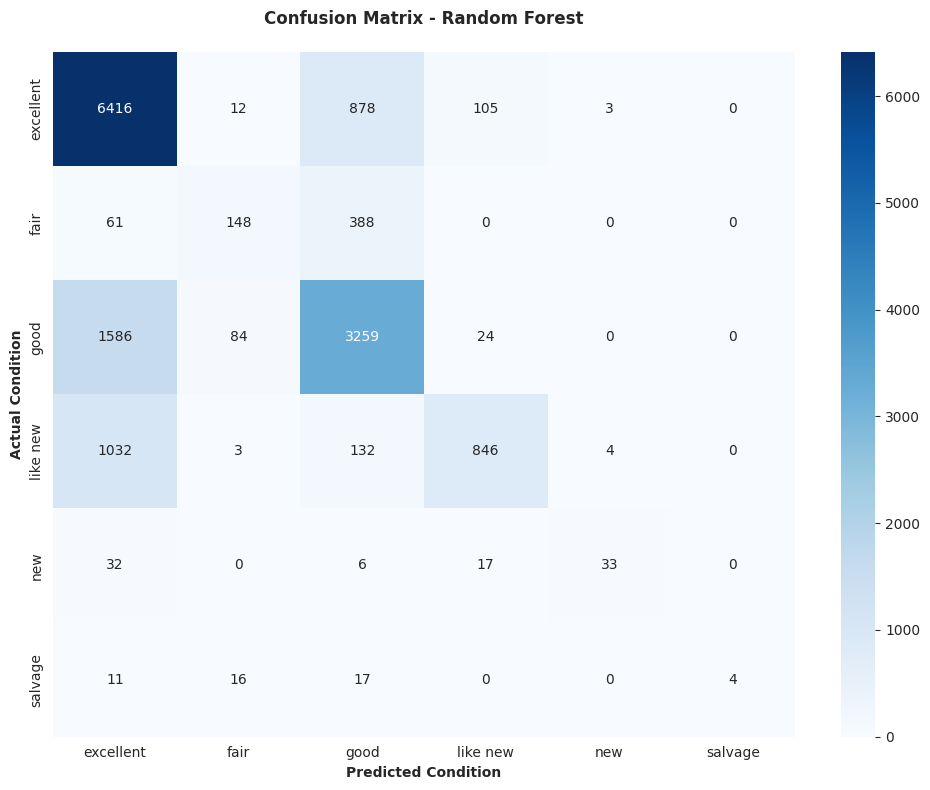

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test_clf, best_predictions_clf)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title(f'Confusion Matrix - {best_model_name_clf}', fontweight='bold', pad=20)
plt.ylabel('Actual Condition', fontweight='bold')
plt.xlabel('Predicted Condition', fontweight='bold')
plt.tight_layout()
plt.show()

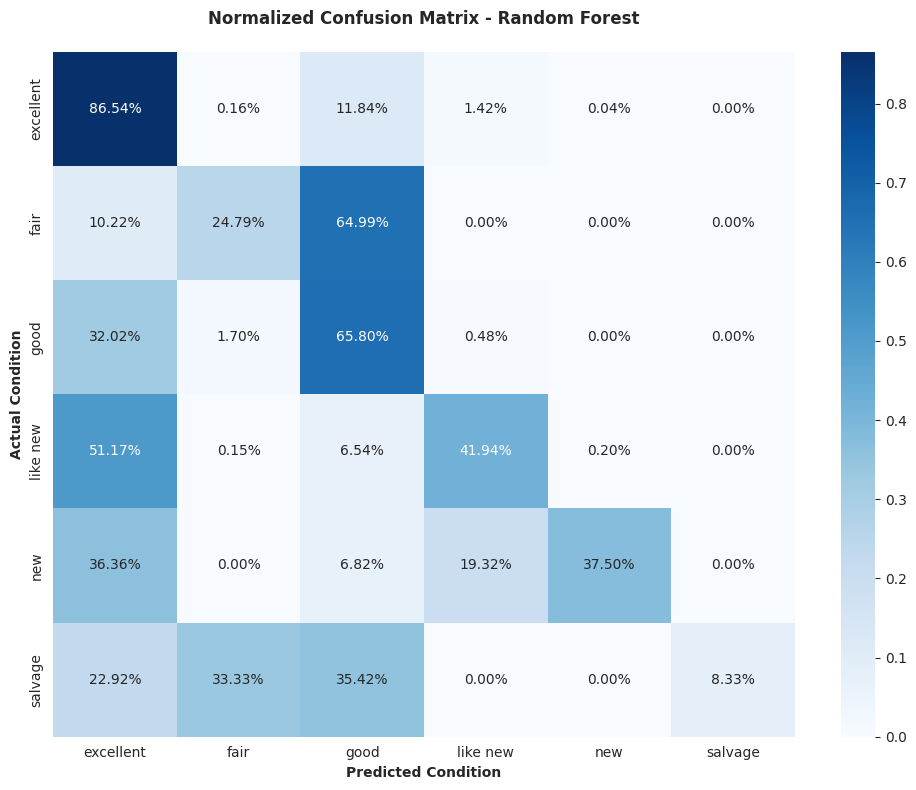

In [45]:
# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title(f'Normalized Confusion Matrix - {best_model_name_clf}', fontweight='bold', pad=20)
plt.ylabel('Actual Condition', fontweight='bold')
plt.xlabel('Predicted Condition', fontweight='bold')
plt.tight_layout()
plt.show()

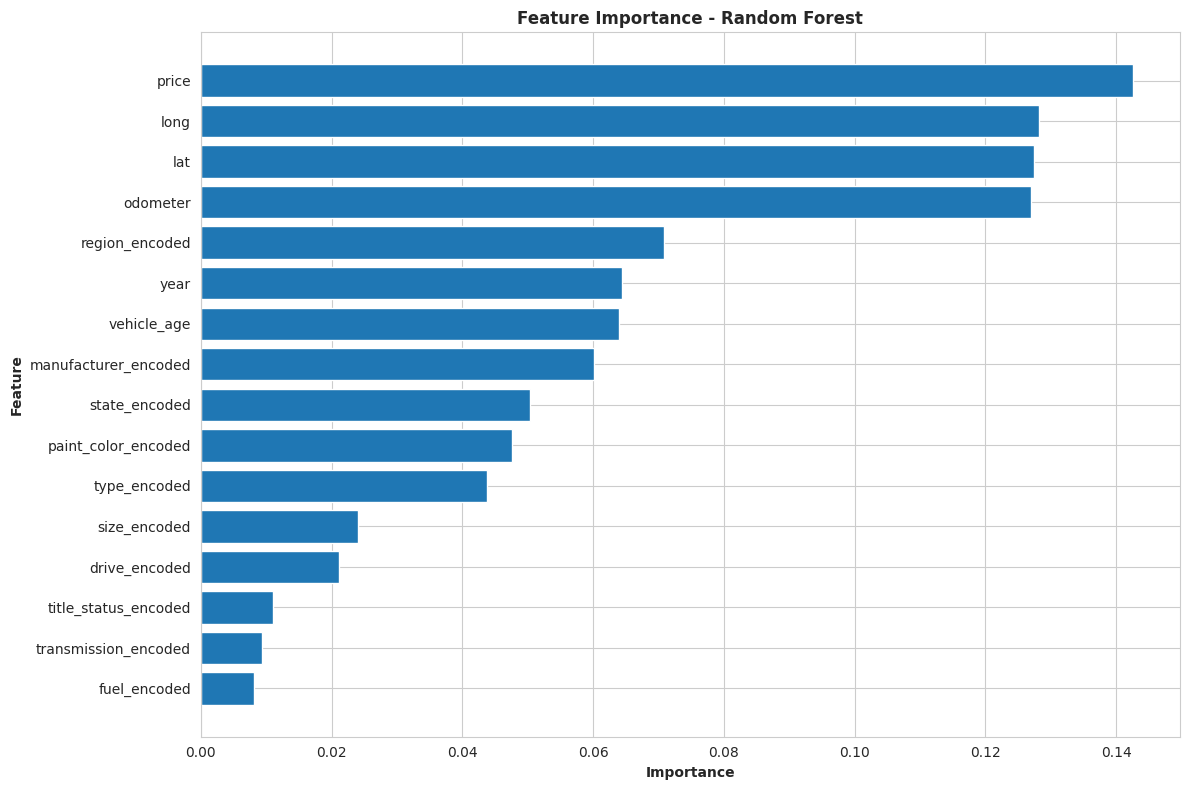


Top 10 Most Important Features:
                 Feature  Importance
0                  price    0.142651
5                   long    0.128190
4                    lat    0.127390
3               odometer    0.127033
15        region_encoded    0.070926
1                   year    0.064440
2            vehicle_age    0.063947
6   manufacturer_encoded    0.060147
14         state_encoded    0.050328
13   paint_color_encoded    0.047618


In [46]:
# Feature importance (for tree-based models)
if hasattr(best_model_clf, 'feature_importances_'):
    feature_importance_clf = pd.DataFrame({
        'Feature': feature_columns_clf,
        'Importance': best_model_clf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance_clf)), feature_importance_clf['Importance'])
    plt.yticks(range(len(feature_importance_clf)), feature_importance_clf['Feature'])
    plt.xlabel('Importance', fontweight='bold')
    plt.ylabel('Feature', fontweight='bold')
    plt.title(f'Feature Importance - {best_model_name_clf}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance_clf.head(10))
else:
    print(f"{best_model_name_clf} does not support feature importance visualization")

## 12. Conclusion and Key Findings

### Summary

This project successfully implemented both regression and classification tasks on a large vehicle dataset with robust evaluation using both train-test split and k-fold cross-validation.

### Key Findings

#### Regression (Price Prediction)
- **Best Model**: Selected based on cross-validation R² score
- **Cross-validation benefits**: Provided more reliable performance estimates
- **Important predictors**: Vehicle age, year, odometer, condition, and manufacturer

#### Classification (Condition Prediction)
- **Best Model**: Selected based on cross-validation accuracy
- **Stratified CV**: Ensured balanced class representation in each fold
- **Important predictors**: Price, vehicle age, odometer, and vehicle type

### Evaluation Strategy Insights

**Train-Test Split (80/20)**:
- ✓ Fast and simple
- ✓ Good for final model testing
- ✗ Results depend on single random split
- ✗ May not represent true performance

**5-Fold Cross-Validation**:
- ✓ More reliable performance estimates (averaged over 5 splits)
- ✓ Better detects overfitting
- ✓ Uses all data for both training and validation
- ✓ Provides standard deviation (uncertainty measure)
- ✗ More computationally expensive (5× training)

### Model Selection Rationale

We selected best models based on **cross-validation scores** rather than single test scores because:
1. CV provides more robust estimates of true model performance
2. Less sensitive to random train-test split
3. Standard deviation indicates model stability
4. Industry best practice for model selection

### Recommendations

1. **For production**: Use CV scores to select model, then retrain on all data
2. **For improvement**: Focus on top features from importance analysis
3. **For imbalanced classes**: Consider SMOTE or class weights
4. **For hyperparameter tuning**: Use GridSearchCV with cross-validation
5. **For deployment**: Monitor performance with both metrics over time

In [47]:
# Final summary
print("\n" + "="*100)
print("PROJECT SUMMARY")
print("="*100)
print(f"\nDataset: {len(df_clean)} vehicles (after cleaning)")
print(f"Original size: {len(df)} vehicles")
print(f"Data retention: {len(df_clean)/len(df)*100:.2f}%")

print("\n" + "-"*100)
print("REGRESSION RESULTS (Price Prediction)")
print("-"*100)
print(f"Best Model: {best_model_name_reg}")
print("\nTrain-Test Split:")
print(f"  Test R²: {regression_results[best_model_name_reg]['test_r2']:.4f}")
print(f"  MAE: ${regression_results[best_model_name_reg]['mae']:,.2f}")
print(f"  RMSE: ${regression_results[best_model_name_reg]['rmse']:,.2f}")
print("\nCross-Validation (5-Fold):")
print(f"  CV R²: {cv_results_reg[best_model_name_reg]['cv_r2_mean']:.4f} ± {cv_results_reg[best_model_name_reg]['cv_r2_std']:.4f}")
print(f"  CV MAE: ${cv_results_reg[best_model_name_reg]['cv_mae_mean']:,.2f} ± ${cv_results_reg[best_model_name_reg]['cv_mae_std']:,.2f}")
print(f"  CV RMSE: ${cv_results_reg[best_model_name_reg]['cv_rmse_mean']:,.2f} ± ${cv_results_reg[best_model_name_reg]['cv_rmse_std']:,.2f}")

print("\n" + "-"*100)
print("CLASSIFICATION RESULTS (Condition Prediction)")
print("-"*100)
print(f"Best Model: {best_model_name_clf}")
print("\nTrain-Test Split:")
print(f"  Test Accuracy: {classification_results[best_model_name_clf]['test_acc']:.4f}")
print(f"  F1 Score: {classification_results[best_model_name_clf]['f1_score']:.4f}")
print("\nCross-Validation (5-Fold Stratified):")
print(f"  CV Accuracy: {cv_results_clf[best_model_name_clf]['cv_acc_mean']:.4f} ± {cv_results_clf[best_model_name_clf]['cv_acc_std']:.4f}")
print(f"  CV F1 Score: {cv_results_clf[best_model_name_clf]['cv_f1_mean']:.4f} ± {cv_results_clf[best_model_name_clf]['cv_f1_std']:.4f}")

print("\n" + "="*100)
print("Analysis Complete!")
print("="*100)


PROJECT SUMMARY

Dataset: 75581 vehicles (after cleaning)
Original size: 426880 vehicles
Data retention: 17.71%

----------------------------------------------------------------------------------------------------
REGRESSION RESULTS (Price Prediction)
----------------------------------------------------------------------------------------------------
Best Model: Random Forest

Train-Test Split:
  Test R²: 0.8139
  MAE: $2,828.16
  RMSE: $5,401.05

Cross-Validation (5-Fold):
  CV R²: 0.8024 ± 0.0118
  CV MAE: $2,825.90 ± $18.37
  CV RMSE: $5,549.04 ± $190.54

----------------------------------------------------------------------------------------------------
CLASSIFICATION RESULTS (Condition Prediction)
----------------------------------------------------------------------------------------------------
Best Model: Random Forest

Train-Test Split:
  Test Accuracy: 0.7082
  F1 Score: 0.6940

Cross-Validation (5-Fold Stratified):
  CV Accuracy: 0.7078 ± 0.0038
  CV F1 Score: 0.6929 ± 0.00

---
# PART 3: MODEL EXPORT FOR BACKEND
---

## 13. Export Models for Flask Backend

We'll save the trained models and encoders so they can be used by the Flask API.

In [48]:
import pickle
import os

# Create models directory
os.makedirs('models', exist_ok=True)

# Save regression model (best model)
with open('models/regression_model.pkl', 'wb') as f:
    pickle.dump(best_model_reg, f)
print("✓ Regression model saved")

# Save classification model (best model)
with open('models/classification_model.pkl', 'wb') as f:
    pickle.dump(best_model_clf, f)
print("✓ Classification model saved")

# Save scalers
with open('models/scaler_reg.pkl', 'wb') as f:
    pickle.dump(scaler_reg, f)
print("✓ Regression scaler saved")

with open('models/scaler_clf.pkl', 'wb') as f:
    pickle.dump(scaler_clf, f)
print("✓ Classification scaler saved")

# Save label encoders (for regression)
with open('models/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders_reg, f)
print("✓ Label encoders saved")

# Save condition encoder
with open('models/condition_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)
print("✓ Condition encoder saved")

print("\n📦 All models exported successfully!")
print(f"📁 Models saved in: {os.path.abspath('models/')}")
print(f"\nBest Regression Model: {best_model_name_reg}")
print(f"Best Classification Model: {best_model_name_clf}")

✓ Regression model saved
✓ Classification model saved
✓ Regression scaler saved
✓ Classification scaler saved
✓ Label encoders saved
✓ Condition encoder saved

📦 All models exported successfully!
📁 Models saved in: /home/pluto/Documents/trashuni/workshop/Vehicle_Price_and__Condition_final/models

Best Regression Model: Random Forest
Best Classification Model: Random Forest
✓ Classification model saved
✓ Regression scaler saved
✓ Classification scaler saved
✓ Label encoders saved
✓ Condition encoder saved

📦 All models exported successfully!
📁 Models saved in: /home/pluto/Documents/trashuni/workshop/Vehicle_Price_and__Condition_final/models

Best Regression Model: Random Forest
Best Classification Model: Random Forest


## Export Models for Flask API

In [49]:
import pickle
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Export regression model
with open('models/regression_model.pkl', 'wb') as f:
    pickle.dump(best_model_reg, f)
print("✓ Regression model exported")

# Export classification model
with open('models/classification_model.pkl', 'wb') as f:
    pickle.dump(best_model_clf, f)
print("✓ Classification model exported")

# Export scalers
with open('models/scaler_reg.pkl', 'wb') as f:
    pickle.dump(scaler_reg, f)
print("✓ Regression scaler exported")

with open('models/scaler_clf.pkl', 'wb') as f:
    pickle.dump(scaler_clf, f)
print("✓ Classification scaler exported")

# Export label encoders for categorical features
with open('models/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders_reg, f)
print("✓ Label encoders exported")

# Export condition encoder
with open('models/condition_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)
print("✓ Condition encoder exported")

print("\n✅ All models exported successfully!")
print("You can now run: python app.py")

✓ Regression model exported
✓ Classification model exported
✓ Regression scaler exported
✓ Classification scaler exported
✓ Label encoders exported
✓ Condition encoder exported

✅ All models exported successfully!
You can now run: python app.py
✓ Classification model exported
✓ Regression scaler exported
✓ Classification scaler exported
✓ Label encoders exported
✓ Condition encoder exported

✅ All models exported successfully!
You can now run: python app.py
